# **First steps in QUEENS** 
***

---
First steps in QUEENS 

In [2]:
import pqueens
import argparse
import os
import time
import sys
import numpy as np
try: import simplejson as json
except ImportError: import json

from  pqueens.resources.resource import parse_resources_from_configuration
from  pqueens.resources.resource import print_resources_status

from pqueens.database.mongodb import MongoDB

from collections import OrderedDict
from pqueens.emulators.gp_emulator import GPEmulator
from pqueens.resources.resource import parse_resources_from_configuration
from pqueens.resources.resource import print_resources_status
from pqueens.designers.designer_factory import DesignerFactory
from collections import OrderedDict



# set input params 
# path to input file in json format 
input_file = '/Users/jonas/work/adco/queens_code/pqueens/example_input_files/baci_config.json'
output_dir ='/Users/jonas/work/adco/queens_code/pqueens/example_input_files'
try:
    with open(input_file, 'r') as f:
        options = json.load(f, object_pairs_hook=OrderedDict)
except:
    raise Exception("config.json did not load properly.")
    
options["input_file"] = input_file
options["output_dir"] = output_dir
    
    

 /Applications/anaconda/envs/test/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
 /Applications/anaconda/envs/test/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.


In [3]:
def create_new_job(db,suggestion,experiment_name,options,resource_name):

    print("Created new job")
    jobs = load_jobs(db, experiment_name)

    job_id = len(jobs) + 1

    i = 0
    params = {}
    for key, variable_meta_data in options['variables'].items():
        params[key] = variable_meta_data
        params[key]['values']=suggestion[i]
        i+=1

    job = {
        'id'           : job_id,
        'params' :       params,
        'expt_dir'     : options['output_dir'],
        'expt_name'    : experiment_name,
        'resource'     : resource_name,
        'driver_type'  : options['driver']['driver_type'],
        'driver_params': options['driver']['driver_params'],
        'status'       : 'new',
        'submit time'  : time.time(),
        'start time'   : None,
        'end time'     : None
    }

    save_job(job, db, experiment_name)

    return job

def load_jobs(db, experiment_name):
    """load the jobs from the database

    Returns
    -------
    jobs : list
        a list of jobs or an empty list
    """
    jobs = db.load(experiment_name, 'jobs')

    if jobs is None:
        jobs = []
    if isinstance(jobs, dict):
        jobs = [jobs]

    return jobs

def save_job(job, db, experiment_name):
    """save a job to the database"""
    db.save(job, experiment_name, 'jobs', {'id' : job['id']})

def tired(db, experiment_name, resource):
    """
    return True if resources is not accepting jobs
    """
    jobs = load_jobs(db, experiment_name)
    if resource.accepting_jobs(jobs):
        return False
    return True

def build_emulator(db, experiment_name, options):
    jobs = load_jobs(db, experiment_name)
    num_jobs = len(jobs)
    num_param = len(options['variables'])
    # init arrays
    y = np.zeros((num_jobs,1))
    x = np.zeros((num_jobs,num_param))
    i = 0
    for job in jobs:
        y[i] = job['result']
        j=0
        print("job['params']{} ".format(job['params']))
        for param in job['params']:
            print("param{} ".format(param))
            x[i,j]=job['params'][param]['values']
            j+=1
            #params[key]['values']=suggestion[i]

        i+=1
    my_emulator = GPEmulator(x,y,options['variables'])
    mean_mean, var_mean = my_emulator.compute_mean()
    print('Mean{} '.format(mean_mean))
    print('Variance of Mean{} '.format(var_mean))

    return my_emulator


Make sure that MongoDB is actually running by typing
`ps -ef | grep mongod | grep -v grep | wc -l | tr -d ' '`

If not start it by


`mongod --dbpath <path to data directory>`

In [4]:
# create resource
resources = parse_resources_from_configuration(options)

 # connect to the database
db_address = options['database']['address']
experiment_name = options['experiment-name']

sys.stderr.write('Using database at %s.\n' % db_address)
db   = MongoDB(database_address=db_address)

# create designer
designer = DesignerFactory.create_designer(options['designer']['type'],
                                           options['variables'],
                                           options['designer']['seed'],
                                           options['designer']['num_samples'])

suggester = designer.sample_generator()



Using database at localhost:27017.


Run Analysis

In [8]:
jobs = load_jobs(db, experiment_name)
for suggestion in suggester:
    processed_suggestion = False
    while not processed_suggestion:
        if resources['my-machine'].accepting_jobs(jobs):

            new_job = create_new_job(db,suggestion,experiment_name,options,'my-machine')

            # Submit the job to the appropriate resource
            process_id = resources['my-machine'].attempt_dispatch(experiment_name,
                                                                  new_job, db_address,
                                                                  options['output_dir'])

            # Set the status of the job appropriately (successfully submitted or not)
            if process_id is None:
                new_job['status'] = 'broken'
                save_job(new_job, db, experiment_name)
            else:
                print("suggested_job[status{} ".format(new_job['status']))
                new_job['status'] = 'pending'
                new_job['proc_id'] = process_id
                save_job(new_job, db, experiment_name)

            processed_suggestion = True
            jobs = load_jobs(db, experiment_name)
            print_resources_status(resources, jobs)

        else: # tired(db, experiment_name, resources['my-machine']):
            time.sleep(options.get('polling-time', 5))
            jobs = load_jobs(db, experiment_name)


        print_resources_status(resources, jobs)
#time.sleep(options.get('polling-time', 30))
#build_emulator(db, experiment_name, options)
# create emulator

Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000001.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 


Submitted job as process: 18268
Submitted job 1 with local scheduler (process id: 18268).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          0         
                *TOTAL*       1          0         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          0         
                *TOTAL*       1          0         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          0         
                *TOTAL*       1          0         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          1         
                *TOTAL*       0          1         

Submitted job as process: 18282
Submitted job 2 with local scheduler (process id: 1828

Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000002.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          1         
                *TOTAL*       1          1         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          2         
                *TOTAL*       0          2         

Submitted job as process: 18300
Submitted job 3 with local scheduler (process id: 18300).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          2         
                *TOTAL*       1          2         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          2         
                *TOTAL*       1          2         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000003.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          2         
                *TOTAL*       1          2         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          3         
                *TOTAL*       0          3         

Submitted job as process: 18313
Submitted job 4 with local scheduler (process id: 18313).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          3         
                *TOTAL*       1          3         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          3         
                *TOTAL*       1          3         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000004.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          3         
                *TOTAL*       1          3         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          4         
                *TOTAL*       0          4         

Submitted job as process: 18325
Submitted job 5 with local scheduler (process id: 18325).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          4         
                *TOTAL*       1          4         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          4         
                *TOTAL*       1          4         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000005.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          4         
                *TOTAL*       1          4         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          5         
                *TOTAL*       0          5         

Submitted job as process: 18337
Submitted job 6 with local scheduler (process id: 18337).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          5         
                *TOTAL*       1          5         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          5         
                *TOTAL*       1          5         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000006.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          5         
                *TOTAL*       1          5         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          6         
                *TOTAL*       0          6         

Submitted job as process: 18351
Submitted job 7 with local scheduler (process id: 18351).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          6         
                *TOTAL*       1          6         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          6         
                *TOTAL*       1          6         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000007.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          6         
                *TOTAL*       1          6         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          7         
                *TOTAL*       0          7         

Submitted job as process: 18363
Submitted job 8 with local scheduler (process id: 18363).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          7         
                *TOTAL*       1          7         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          7         
                *TOTAL*       1          7         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000008.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          7         
                *TOTAL*       1          7         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          8         
                *TOTAL*       0          8         

Submitted job as process: 18378
Submitted job 9 with local scheduler (process id: 18378).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          8         
                *TOTAL*       1          8         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          8         
                *TOTAL*       1          8         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000009.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          8         
                *TOTAL*       1          8         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          9         
                *TOTAL*       0          9         

Submitted job as process: 18392
Submitted job 10 with local scheduler (process id: 18392).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          9         
                *TOTAL*       1          9         


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          9         
                *TOTAL*       1          9         



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000010.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          10        
                *TOTAL*       0          10        

Submitted job as process: 18403
Submitted job 11 with local scheduler (process id: 18403).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          10        
                *TOTAL*       1          10        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          10        
                *TOTAL*       1          10        



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000011.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          10        
                *TOTAL*       1          10        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          11        
                *TOTAL*       0          11        

Submitted job as process: 18417
Submitted job 12 with local scheduler (process id: 18417).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          11        
                *TOTAL*       1          11        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          11        
                *TOTAL*       1          11        



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000012.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          11        
                *TOTAL*       1          11        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          12        
                *TOTAL*       0          12        

Submitted job as process: 18430
Submitted job 13 with local scheduler (process id: 18430).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          12        
                *TOTAL*       1          12        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          12        
                *TOTAL*       1          12        



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000013.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          12        
                *TOTAL*       1          12        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          13        
                *TOTAL*       0          13        

Submitted job as process: 18441
Submitted job 14 with local scheduler (process id: 18441).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          13        
                *TOTAL*       1          13        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          13        
                *TOTAL*       1          13        



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000014.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          13        
                *TOTAL*       1          13        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          14        
                *TOTAL*       0          14        

Submitted job as process: 18454
Submitted job 15 with local scheduler (process id: 18454).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          14        
                *TOTAL*       1          14        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          14        
                *TOTAL*       1          14        



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000015.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          14        
                *TOTAL*       1          14        



Created new job
starting process
output_file<_io.TextIOWrapper name='/Users/jonas/work/adco/queens_code/pqueens/example_input_files/output/00000016.out' mode='w' encoding='UTF-8'>
suggested_job[statusnew 



Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    0          15        
                *TOTAL*       0          15        

Submitted job as process: 18467
Submitted job 16 with local scheduler (process id: 18467).

Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          15        
                *TOTAL*       1          15        


Resources:      NAME          PENDING    COMPLETE
                ----          -------    --------
                my-machine    1          15        
                *TOTAL*       1          15        



In [9]:
    my_emulator = build_emulator(db, experiment_name, options)

job['params']{'beta': {'distribution': 'normal', 'type': 'FLOAT', 'distribution_parameter': [400000, 10000], 'values': 2297667.8503530347, 'max': 5000000, 'size': 1, 'min': 1500000}, 'youngs': {'distribution': 'normal', 'type': 'FLOAT', 'distribution_parameter': [400000, 10000], 'values': 2853356.202855057, 'max': 5000000, 'size': 1, 'min': 1000000}} 
parambeta 
paramyoungs 
job['params']{'beta': {'distribution': 'normal', 'type': 'FLOAT', 'distribution_parameter': [400000, 10000], 'values': 3692913.552080499, 'max': 5000000, 'size': 1, 'min': 1500000}, 'youngs': {'distribution': 'normal', 'type': 'FLOAT', 'distribution_parameter': [400000, 10000], 'values': 1306817.8838750883, 'max': 5000000, 'size': 1, 'min': 1000000}} 
parambeta 
paramyoungs 
job['params']{'beta': {'distribution': 'normal', 'type': 'FLOAT', 'distribution_parameter': [400000, 10000], 'values': 2386356.143244072, 'max': 5000000, 'size': 1, 'min': 1500000}, 'youngs': {'distribution': 'normal', 'type': 'FLOAT', 'distrib

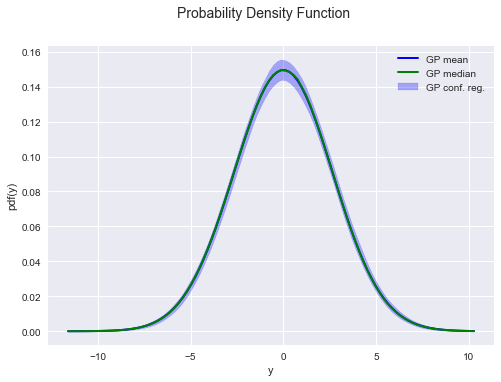

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns # makes plots more pretty 
import numpy as np

my_pdf_hifi, y_plot_hifi  = my_emulator.compute_pdf()
fig = plt.figure()
fig.suptitle('Probability Density Function', fontsize=14)
line1, = plt.plot(y_plot_hifi, my_pdf_hifi['mean'], lw=2, color='blue',label='GP mean')
line2, = plt.plot(y_plot_hifi, my_pdf_hifi['median'], lw=2, color='green',label='GP median')
plt.fill_between(y_plot_hifi,my_pdf_hifi['quant_low'], my_pdf_hifi['quant_high'],
                  color='blue',alpha = 0.3,label='GP conf. reg.')

plt.ylabel('pdf(y)')
plt.xlabel('y')
plt.legend()
plt.show()


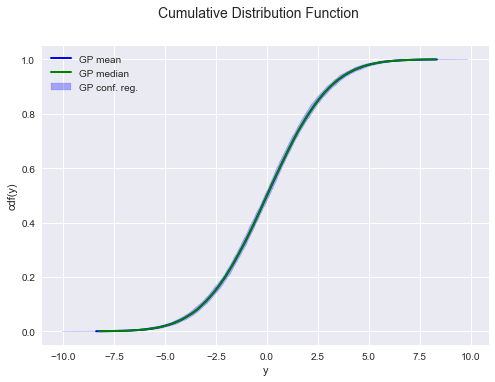

In [18]:
cdf_val, sample_values = my_emulator.compute_cdf()

fig = plt.figure()
fig.suptitle('Cumulative Distribution Function', fontsize=14)
x = np.append(sample_values['q_lower_bound'],
              sample_values['q_upper_bound'][::-1])

y = np.append(cdf_val,cdf_val[::-1])


p = plt.Polygon(np.c_[x,y], color="blue",alpha=0.3,label='GP conf. reg.')
ax = plt.gca()
ax.add_patch(p)
line1, = plt.plot(sample_values['mean'], cdf_val, lw=2, color='blue',
                  label='GP mean')
line4, = plt.plot(sample_values['median'], cdf_val, lw=2, color='green',
                  label='GP median')

plt.legend()

plt.ylabel('cdf(y)')
plt.xlabel('y')
plt.show()

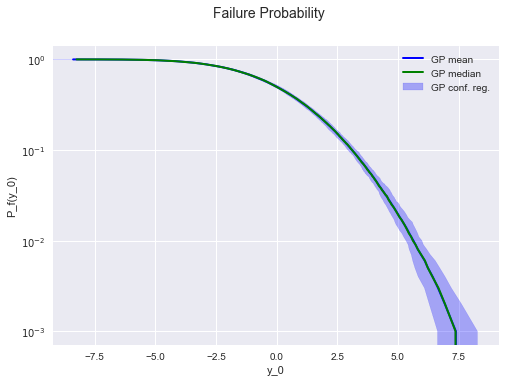

In [20]:
y_quantile, my_fail_prob = my_emulator.compute_failure_probability_function()
fig = plt.figure()
fig.suptitle('Failure Probability', fontsize=14)
plt.ylabel('P_f(y_0)')
plt.xlabel('y_0')

line1, = plt.plot(y_quantile['mean'],my_fail_prob, lw=2, color='blue',label='GP mean')
line2, = plt.plot(y_quantile['median'],my_fail_prob, lw=2, color='green',label='GP median')

x = np.append(y_quantile['q_upper_bound'],
              y_quantile['q_lower_bound'][::-1])

y = np.append(my_fail_prob,my_fail_prob[::-1])

p = plt.Polygon(np.c_[x,y], color="blue",alpha=0.3,label='GP conf. reg.')
ax = plt.gca()
ax.add_patch(p)

plt.legend()
ax.set_yscale('log')
plt.show()